In [235]:
import json
import os
import csv
import rdflib
from rdflib import ConjunctiveGraph, Graph, URIRef, Literal, Namespace
from rdflib.namespace import SKOS, DCTERMS, RDF, RDFS, XSD

from openai import OpenAI
from langchain.chains import GraphSparqlQAChain
from langchain_community.graphs import RdfGraph
from langchain_openai import ChatOpenAI

import io
import pydotplus
from IPython.display import display, Image
from rdflib.tools.rdf2dot import rdf2dot

import requests
import xml.etree.ElementTree as ET
from html.parser import HTMLParser
from html import unescape
import re
from keybert import KeyBERT

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [236]:
# Opening config file -> this config file is found in a config folder, the config structure is:
# {"access_token_zenodo":"......"
# "openai_api_key":"......"}

config = open('config.json', 'r')
config = json.load(config)

os.environ['OPENAI_API_KEY'] = config['openai_api_key']

In [250]:
# Load the JSON dataset
with open('text_RDF_gt.json', 'r') as file:
    data = json.load(file)

# Access the dataset
dataset = data['dataset']

In [5]:
def load_graph(data):
    g = rdflib.Graph()
    g.parse(data=data, format="turtle")
    return g

In [237]:
def print_rdf(rdf):
    g = rdflib.Graph()
    g.parse(data=rdf, format="turtle")

    for s, p, o in g:
        print(s, p, o)

In [147]:
# Namespaces
EX = Namespace("http://example.org/")
NS0 = Namespace("http://soilwise-he.github.io/soil-health/")
agrovoc = Namespace("http://aims.fao.org/aos/agrovoc/")
glosis_lh = Namespace("http://w3id.org/glosis/model/layerhorizon/")

### A simple example of converting text to RDF statements

In [7]:
# Raw texts from the report
print(dataset[0]['text'])

Soil: is the top terrestrial layer of the Earth; is composed of a mixture of mineral and organic compounds, water, air and living organisms; is one of the most complex biomaterials on earth (Young and Crawford, 2004); provides multiple functions that support the delivery of ecosystem services, including the life support function; varies naturally in both space and time over a range of scales.


In [8]:
# Corresponding ground-truth RDF statements
print(dataset[0]['rdf_graph_turtle'])

@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix dc: <http://purl.org/dc/terms/> .
@prefix ns0: <http://soilwise-he.github.io/soil-health/> .
@prefix agrovoc: <http://aims.fao.org/aos/agrovoc/> .
@prefix agrontology: <http://aims.fao.org/aos/agrontology#> .

agrovoc:c_7156 a skos:Concept;
    skos:prefLabel "Soil";
    skos:definition "The top terrestrial layer of the Earth.";
    agrontology:isComposedOf agrovoc:c_4857, agrovoc:c_5384, agrovoc:c_8309, agrovoc:c_224, agrovoc:c_49904;
    skos:broader ns0:Biomaterials;
    dc:source ns0:YoungCrawford2004.

ns0:Biomaterials a skos:Concept;
    skos:prefLabel "Biomaterials".

agrovoc:c_4857 a skos:Concept;
    skos:prefLabel "Minerals" .

agrovoc:c_5384 a skos:Concept;
    skos:prefLabel "Organic Compounds" .

agrovoc:c_8309 a skos:Concept;
    skos:prefLabel "Water" .

agrovoc:c_224 a skos:Concept;
    skos:prefLabel "Air" .

agrovoc:c_49904 a skos:Concept;
    skos:prefLabel "Organisms";
    skos:altLabel "Living Organisms

In [10]:
g = load_graph(dataset[0]['rdf_graph_turtle'])

In [11]:
print_rdf(dataset[0]['rdf_graph_turtle'])

http://soilwise-he.github.io/soil-health/SoilVariability http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
http://aims.fao.org/aos/agrovoc/c_5384 http://www.w3.org/2004/02/skos/core#prefLabel Organic Compounds
http://aims.fao.org/aos/agrovoc/c_4857 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
http://aims.fao.org/aos/agrovoc/c_7156 http://www.w3.org/2004/02/skos/core#broader http://soilwise-he.github.io/soil-health/Biomaterials
http://soilwise-he.github.io/soil-health/SoilVariability http://www.w3.org/2004/02/skos/core#definition Soil varies naturally in both space and time over a range of scales.
http://aims.fao.org/aos/agrovoc/c_49904 http://www.w3.org/2004/02/skos/core#prefLabel Organisms
http://aims.fao.org/aos/agrovoc/c_1348040570280 http://www.w3.org/2004/02/skos/core#prefLabel Ecosystem Services
http://soilwise-he.github.io/soil-health/YoungCrawford2004 http://www.w3.org/1999/02/22-rdf-syntax


(process:19028): Pango-WARNING **: 11:38:59.176: couldn't load font "DejaVu Sans Bold Not-Rotated 14", falling back to "Sans Bold Not-Rotated 14", expect ugly output.

(process:19028): Pango-WARNING **: 11:38:59.186: couldn't load font "DejaVu Sans Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(process:19028): Pango-WARNING **: 11:38:59.186: couldn't load font "DejaVu Sans Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.



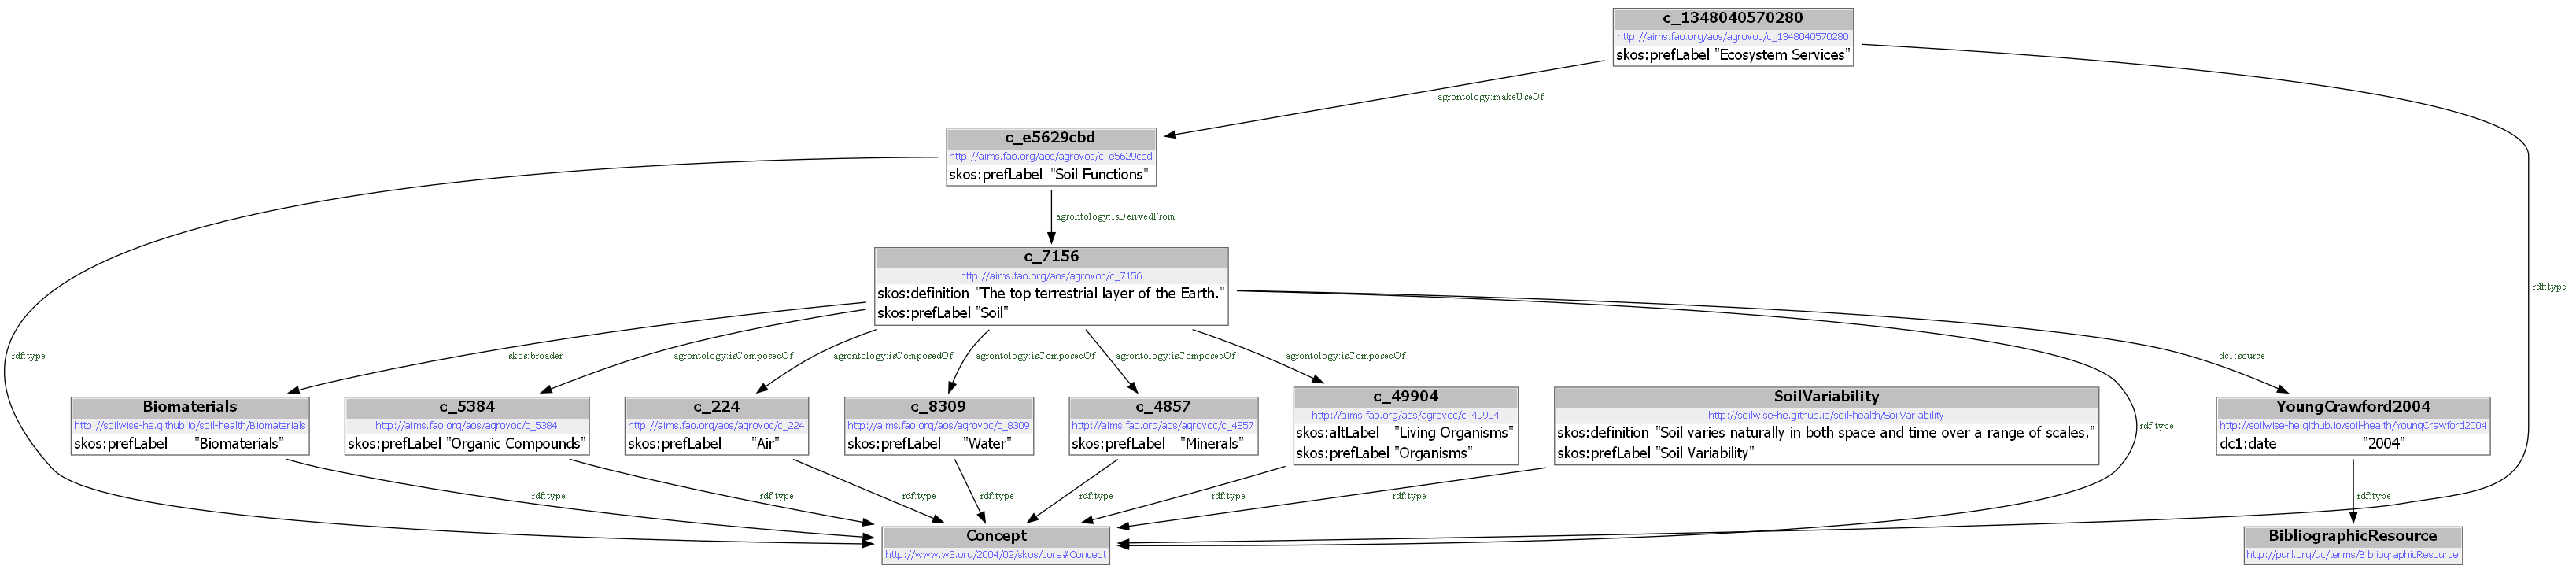

In [12]:
# Visualize the graph
def visualize(g):
    stream = io.StringIO()
    rdf2dot(g, stream, opts = {display})
    dg = pydotplus.graph_from_dot_data(stream.getvalue())
    png = dg.create_png()
    display(Image(png))

visualize(g)

### Convert text to RDF statements with LLMs: a zero-shot example

In [13]:
system_prompt = """You are a top-tier algorithm designed for extracting information from unstructured text to build a knowledge graph."""

In [16]:
# Prompt for zero-shot learning
prompt_0 = f"""
Please help me convert this text to an RDF knowledge graph using only the combination of SKOS Core and Dublin Core as ontologies and 'ex:' as a prefix:
'{dataset[1]['text']}'
Please think step by step, and only the final result should be output, i.e., the pure RDF knowledge graph serialized in Turtle without any comments. Thank you!
"""

In [47]:
client = OpenAI()

completion = client.chat.completions.create(
    model="chatgpt-4o-latest",
    messages=[
        {"role": "system", "content": system_prompt},
        {
            "role": "user",
            "content": prompt_0
        }
    ]
)

print(completion.choices[0].message.content)

```turtle
@prefix ex: <http://example.org/> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix dcterms: <http://purl.org/dc/terms/> .

ex:Soil a skos:Concept ;
    skos:prefLabel "Soil" ;
    dcterms:description "Medium under study to understand sustainable management and protection measures." .

ex:SustainableSoilManagement a skos:Concept ;
    skos:prefLabel "Sustainable Soil Management" ;
    dcterms:description "Managing soil sustainably to maintain ecosystem services." ;
    skos:related ex:Soil ;
    skos:related ex:SoilDevelopment ;
    skos:related ex:ClimaticConditions .

ex:SoilDevelopment a skos:Concept ;
    skos:prefLabel "Soil Development" ;
    dcterms:description "Process of soil development under management and climatic conditions." ;
    skos:related ex:Soil ;
    skos:related ex:SustainableSoilManagement ;
    skos:related ex:ClimaticConditions .

ex:ClimaticConditions a skos:Concept ;
    skos:prefLabel "Climatic Conditions" ;
    dcterms:description "

In [70]:
rdf_data_llm_0 = completion.choices[0].message.content.replace('```turtle\n', '')
rdf_data_llm_0 = rdf_data_llm_0.replace('\n```', '')

print_rdf(rdf_data_llm_0)
g_0 = load_graph(rdf_data_llm_0)

http://example.org/SustainableSoilManagement http://purl.org/dc/terms/description Managing soil sustainably to maintain ecosystem services.
http://example.org/SoilSealing http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
http://example.org/SoilSealing http://www.w3.org/2004/02/skos/core#prefLabel Soil Sealing
http://example.org/ClimaticConditions http://www.w3.org/2004/02/skos/core#related http://example.org/SustainableSoilManagement
http://example.org/SoilDegradation http://www.w3.org/2004/02/skos/core#related http://example.org/Urbanisation
http://example.org/SoilSealing http://www.w3.org/2004/02/skos/core#related http://example.org/SoilDegradation
http://example.org/Soil http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
http://example.org/SustainableSoilManagement http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
http://example.org/SustainableSoilManagement h

In [72]:
def ex2ns0(g):
    # Bind the new namespace with prefix 'ns0'
    g.bind("ns0", NS0)

    # Remove the old 'ex' namespace binding
    # Note: rdflib doesn't provide a direct method to remove a namespace,
    # so we'll recreate the graph without the 'ex' prefix
    # Create a new graph with the desired namespaces
    new_g = Graph()

    # Bind existing namespaces except 'ex'
    for prefix, namespace in g.namespaces():
        if prefix != 'ex':
            new_g.bind(prefix, namespace)

    # Bind the new 'ns0' namespace
    new_g.bind("ns0", NS0)

    # Iterate over all triples and replace the namespace
    for s, p, o in g:
        # Replace subject namespace if it uses EX
        if isinstance(s, URIRef) and s.startswith(EX):
            s = URIRef(s.replace(EX, NS0))
        # Replace predicate namespace if it uses EX
        if isinstance(p, URIRef) and p.startswith(EX):
            p = URIRef(p.replace(EX, NS0))
        # Replace object namespace if it uses EX
        if isinstance(o, URIRef) and o.startswith(EX):
            o = URIRef(o.replace(EX, NS0))
        new_g.add((s, p, o))

    return new_g

g_0 = ex2ns0(g_0)
print(g_0.serialize(format="turtle"))

@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix ns0: <http://soilwise-he.github.io/soil-health/> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .

ns0:SoilSealing a skos:Concept ;
    dcterms:description "Covering of soil with impermeable materials leading to irreversible loss of soil functions." ;
    skos:prefLabel "Soil Sealing" ;
    skos:related ns0:Soil,
        ns0:SoilDegradation .

ns0:EcosystemServices a skos:Concept ;
    dcterms:description "Benefits provided by functioning ecosystems due to healthy soils." ;
    skos:prefLabel "Ecosystem Services" ;
    skos:related ns0:Soil,
        ns0:SustainableSoilManagement .

ns0:LandCultivation a skos:Concept ;
    dcterms:description "The practice of preparing and using land for crops, which may cause soil degradation." ;
    skos:prefLabel "Land Cultivation" ;
    skos:related ns0:SoilDegradation .

ns0:Urbanisation a skos:Concept ;
    dcterms:description "Development of land into urban spaces, resulting in altere

In [73]:
def concept2agrovoc(g):

    # Load the CSV file
    pref_label_map = {}
    alt_label_map = {}
    with open("ontovocabs/agrovoc.csv", encoding="utf8") as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            new_uri = row['Concept']
            pref_label = row['prefLabel'].lower()
            alt_labels = row['altLabel'].split(';') if row['altLabel'] else []
            pref_label_map[pref_label] = new_uri
            for alt_label in alt_labels:
                alt_label = alt_label.strip().lower()  # Clean and normalize altLabel
                if alt_label:
                    alt_label_map[alt_label] = new_uri


    # Iterate over the graph and process matching prefLabel and altLabel
    for s, p, o in g:
        label = str(o).lower()
        if p == rdflib.namespace.SKOS.prefLabel and label in pref_label_map:
            new_uri = rdflib.URIRef(pref_label_map[label])
            # Collect all triples with the old subject
            for s2, p2, o2 in g.triples((s, None, None)):
                if s2 != new_uri:
                    g.add((new_uri, p2, o2))
                    g.remove((s2, p2, o2))
            for s3, p3, o3 in g.triples((None, None, s)):
                if o3 != new_uri:
                    g.add((s3, p3, new_uri))
                    g.remove((s3, p3, o3))
        elif p == rdflib.namespace.SKOS.prefLabel and label in alt_label_map:
            # Add skos:closeMatch triples
            close_match_uri = rdflib.URIRef(alt_label_map[label])
            g.add((s, rdflib.namespace.SKOS.closeMatch, close_match_uri))

    g.bind("agrovoc", agrovoc)

    return g

g_0 = concept2agrovoc(g_0)

# Print the updated knowledge graph
print(g_0.serialize(format="turtle"))

@prefix agrovoc: <http://aims.fao.org/aos/agrovoc/> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix ns0: <http://soilwise-he.github.io/soil-health/> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .

agrovoc:c_f9554e7c a skos:Concept ;
    dcterms:description "Covering of soil with impermeable materials leading to irreversible loss of soil functions." ;
    skos:prefLabel "Soil Sealing" ;
    skos:related agrovoc:c_7156,
        agrovoc:c_7168 .

agrovoc:c_1348040570280 a skos:Concept ;
    dcterms:description "Benefits provided by functioning ecosystems due to healthy soils." ;
    skos:prefLabel "Ecosystem Services" ;
    skos:related agrovoc:c_7156,
        ns0:SustainableSoilManagement .

ns0:LandCultivation a skos:Concept ;
    dcterms:description "The practice of preparing and using land for crops, which may cause soil degradation." ;
    skos:prefLabel "Land Cultivation" ;
    skos:related agrovoc:c_7168 .

ns0:Urbanisation a skos:Concept ;
    dcterms:descriptio


(process:22276): Pango-WARNING **: 23:10:41.980: couldn't load font "DejaVu Sans Bold Not-Rotated 14", falling back to "Sans Bold Not-Rotated 14", expect ugly output.

(process:22276): Pango-WARNING **: 23:10:41.985: couldn't load font "DejaVu Sans Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(process:22276): Pango-WARNING **: 23:10:41.985: couldn't load font "DejaVu Sans Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.



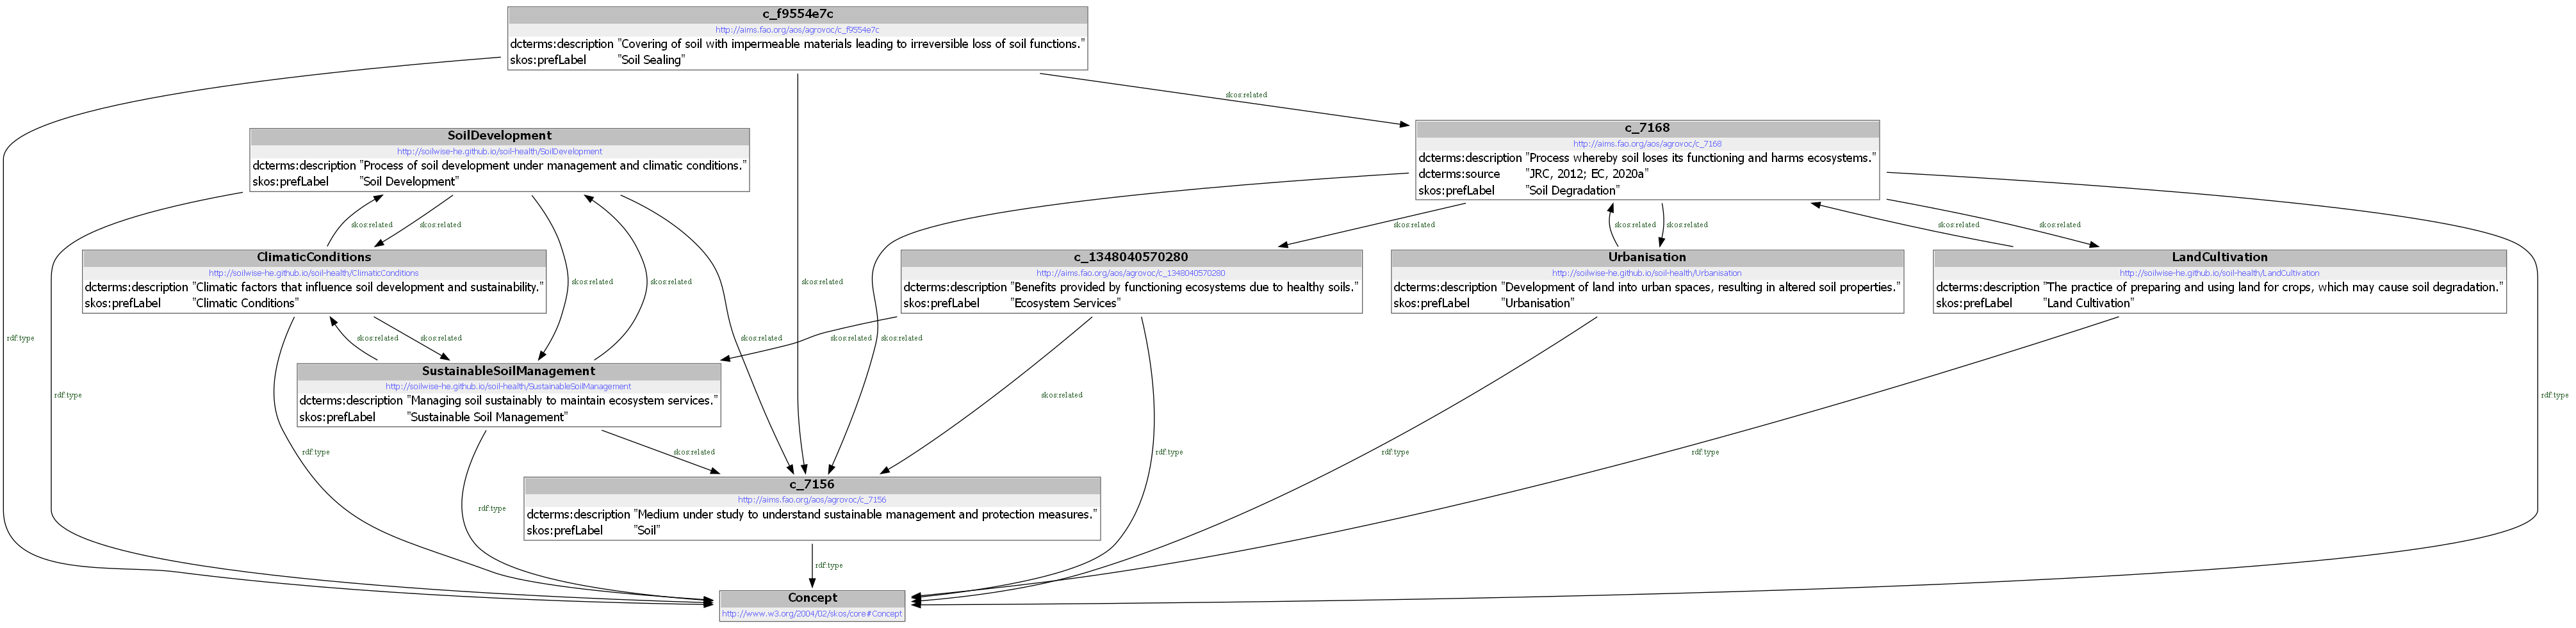

In [74]:
visualize(g_0)

### A few-shot (one-shot) example

In [95]:
# Prompt for one-shot learning
prompt_1 = f"""
Now I will show an example of how to convert text to an RDF knowledge graph using SKOS Core and Dublin Core as ontologies. Here is the raw text:
'{dataset[0]['text']}'
This is the ground-truth RDF knowledge graph for this text:
'{dataset[0]['rdf_graph_turtle']}'
Follow this example, please help me convert the following text to an RDF knowledge graph, using only the combination of SKOS Core and Dublin Core as ontologies and 'ns0:' as a prefix:
'{dataset[1]['text']}'
Please think step by step, and only the final result should be output, i.e., the pure RDF knowledge graph in Turtle format without any comments. Thank you!
"""

In [96]:
completion = client.chat.completions.create(
    model="chatgpt-4o-latest",
    messages=[
        {"role": "system", "content": system_prompt},
        {
            "role": "user",
            "content": prompt_1
        }
    ]
)

print(completion.choices[0].message.content)

```turtle
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix dc: <http://purl.org/dc/terms/> .
@prefix ns0: <http://soilwise-he.github.io/soil-health/> .
@prefix agrovoc: <http://aims.fao.org/aos/agrovoc/> .
@prefix agrontology: <http://aims.fao.org/aos/agrontology#> .

agrovoc:c_7156 a skos:Concept;
    skos:prefLabel "Soil";
    agrontology:isManagedBy ns0:SustainableManagement;
    agrontology:hasState ns0:SoilState.

ns0:SustainableManagement a skos:Concept;
    skos:prefLabel "Sustainable Management".

ns0:SoilState a skos:Concept;
    skos:prefLabel "Soil State";
    skos:definition "Knowledge is needed about the state of soil and how it develops under current and future management and climatic conditions.".

agrovoc:c_e5629cbd a skos:Concept;
    skos:prefLabel "Soil Functions";
    agrontology:isAffectedBy ns0:DegradedSoils.

agrovoc:c_1348040570280 a skos:Concept;
    skos:prefLabel "Ecosystem Services";
    agrontology:makeUseOf agrovoc:c_e5629cbd.

ns0:DegradedSo

In [129]:
rdf_data_llm_1 = completion.choices[0].message.content.replace('```turtle\n', '')
rdf_data_llm_1 = rdf_data_llm_1.replace('\n```', '') 

print_rdf(rdf_data_llm_1)
g_1 = load_graph(rdf_data_llm_1)

http://aims.fao.org/aos/agrovoc/c_7156 http://aims.fao.org/aos/agrontology#isManagedBy http://soilwise-he.github.io/soil-health/SustainableManagement
http://soilwise-he.github.io/soil-health/SoilState http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
http://aims.fao.org/aos/agrovoc/c_e5629cbd http://aims.fao.org/aos/agrontology#isAffectedBy http://soilwise-he.github.io/soil-health/DegradedSoils
http://soilwise-he.github.io/soil-health/SustainableManagement http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
http://soilwise-he.github.io/soil-health/SustainableManagement http://www.w3.org/2004/02/skos/core#prefLabel Sustainable Management
http://aims.fao.org/aos/agrovoc/c_1348040570280 http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos/core#Concept
http://soilwise-he.github.io/soil-health/DegradedSoils http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://www.w3.org/2004/02/skos

In [130]:
g_1 = concept2agrovoc(g_1)

# Print the updated knowledge graph
print(g_1.serialize(format="turtle"))

@prefix agrontology: <http://aims.fao.org/aos/agrontology#> .
@prefix agrovoc: <http://aims.fao.org/aos/agrovoc/> .
@prefix dc1: <http://purl.org/dc/terms/> .
@prefix ns0: <http://soilwise-he.github.io/soil-health/> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .

agrovoc:c_1348040570280 a skos:Concept ;
    agrontology:makeUseOf agrovoc:c_e5629cbd ;
    skos:prefLabel "Ecosystem Services" .

agrovoc:c_7156 a skos:Concept ;
    agrontology:hasState ns0:SoilState ;
    agrontology:isManagedBy ns0:SustainableManagement ;
    skos:prefLabel "Soil" .

agrovoc:c_f9554e7c a skos:Concept ;
    skos:definition "Soil functions are largely and irreversibly lost." ;
    skos:prefLabel "Soil Sealing" .

ns0:EC2020a a dc1:BibliographicResource ;
    dc1:date "2020" .

ns0:JRC2012 a dc1:BibliographicResource ;
    dc1:date "2012" .

agrovoc:c_e5629cbd a skos:Concept ;
    agrontology:isAffectedBy ns0:DegradedSoils ;
    skos:prefLabel "Soil Functions" .

ns0:DegradedSoils a skos:Concept ;
 

In [135]:
# Load the valid agrontology terms from the CSV file
def load_agrontology_terms(csv_file_path):
    with open(csv_file_path, newline='') as csvfile:
        reader = csv.reader(csvfile)
        agrontology_terms = [row[0].strip() for row in reader]  # Assuming one term per row
    return agrontology_terms

# Generate embeddings using OpenAI API
def get_embedding(text):
    response = client.embeddings.create(
    model="text-embedding-3-large",
    input=text
    )
    return np.array(response.data[0].embedding)

# Compare custom terms to valid terms using cosine similarity
def find_closest_term(custom_term, valid_terms):
    custom_embedding = get_embedding(custom_term)
    valid_embeddings = [get_embedding(term) for term in valid_terms]
    
    similarities = cosine_similarity([custom_embedding], valid_embeddings)[0]
    best_match_index = np.argmax(similarities)
    
    return valid_terms[best_match_index], similarities[best_match_index]

# Main function to check and correct the RDF knowledge graph
def check_and_correct_rdf(rdf_string, csv_file_path):
    # Step 1: Load valid agrontology terms
    agrontology_terms = load_agrontology_terms(csv_file_path)
    
    # Step 2: Extract predicates from RDF graph
    graph = rdflib.Graph()
    graph.parse(data=rdf_string, format="turtle")
    
    # Step 3: Iterate over all predicates and check if they are valid
    for s, pred, o in graph:
        pred_str = str(pred)
        if pred_str.startswith("http://aims.fao.org/aos/agrontology#"):
            predicate_short = pred_str.split("#")[-1]  # Get the short version of the predicate
            if predicate_short not in agrontology_terms:
                # If the term is not found, find the closest valid term
                closest_term, similarity = find_closest_term(predicate_short, agrontology_terms)
                if similarity > 0.5:  # Threshold for correction
                    # Replace the wrong predicate with the closest valid term
                    new_predicate_uri = f"http://aims.fao.org/aos/agrontology#{closest_term}"
                    graph.set((s, rdflib.URIRef(new_predicate_uri), o))
                    graph.remove((s, pred, o))
                else:
                    graph.remove((s, pred, o))
    
    # Step 4: Output the corrected RDF triples
    corrected_rdf_turtle = graph.serialize(format="turtle")
    
    return corrected_rdf_turtle

corrected_rdf_turtle = check_and_correct_rdf(g_1.serialize(format="turtle"), 'ontovocabs/agrontology.csv')

g_1 = load_graph(corrected_rdf_turtle)
print(g_1.serialize(format="turtle"))

@prefix agrontology: <http://aims.fao.org/aos/agrontology#> .
@prefix agrovoc: <http://aims.fao.org/aos/agrovoc/> .
@prefix dc1: <http://purl.org/dc/terms/> .
@prefix ns0: <http://soilwise-he.github.io/soil-health/> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .

agrovoc:c_1348040570280 a skos:Concept ;
    agrontology:makeUseOf agrovoc:c_e5629cbd ;
    skos:prefLabel "Ecosystem Services" .

agrovoc:c_7156 a skos:Concept ;
    agrontology:hasType ns0:SoilState ;
    agrontology:isMeasuredBy ns0:SustainableManagement ;
    skos:prefLabel "Soil" .

agrovoc:c_f9554e7c a skos:Concept ;
    skos:definition "Soil functions are largely and irreversibly lost." ;
    skos:prefLabel "Soil Sealing" .

ns0:EC2020a a dc1:BibliographicResource ;
    dc1:date "2020" .

ns0:JRC2012 a dc1:BibliographicResource ;
    dc1:date "2012" .

agrovoc:c_e5629cbd a skos:Concept ;
    agrontology:isAffectedBy ns0:DegradedSoils ;
    skos:prefLabel "Soil Functions" .

ns0:DegradedSoils a skos:Concept ;
 


(process:24276): Pango-WARNING **: 10:56:41.239: couldn't load font "DejaVu Sans Bold Not-Rotated 14", falling back to "Sans Bold Not-Rotated 14", expect ugly output.

(process:24276): Pango-WARNING **: 10:56:41.256: couldn't load font "DejaVu Sans Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(process:24276): Pango-WARNING **: 10:56:41.260: couldn't load font "DejaVu Sans Not-Rotated 14", falling back to "Sans Not-Rotated 14", expect ugly output.



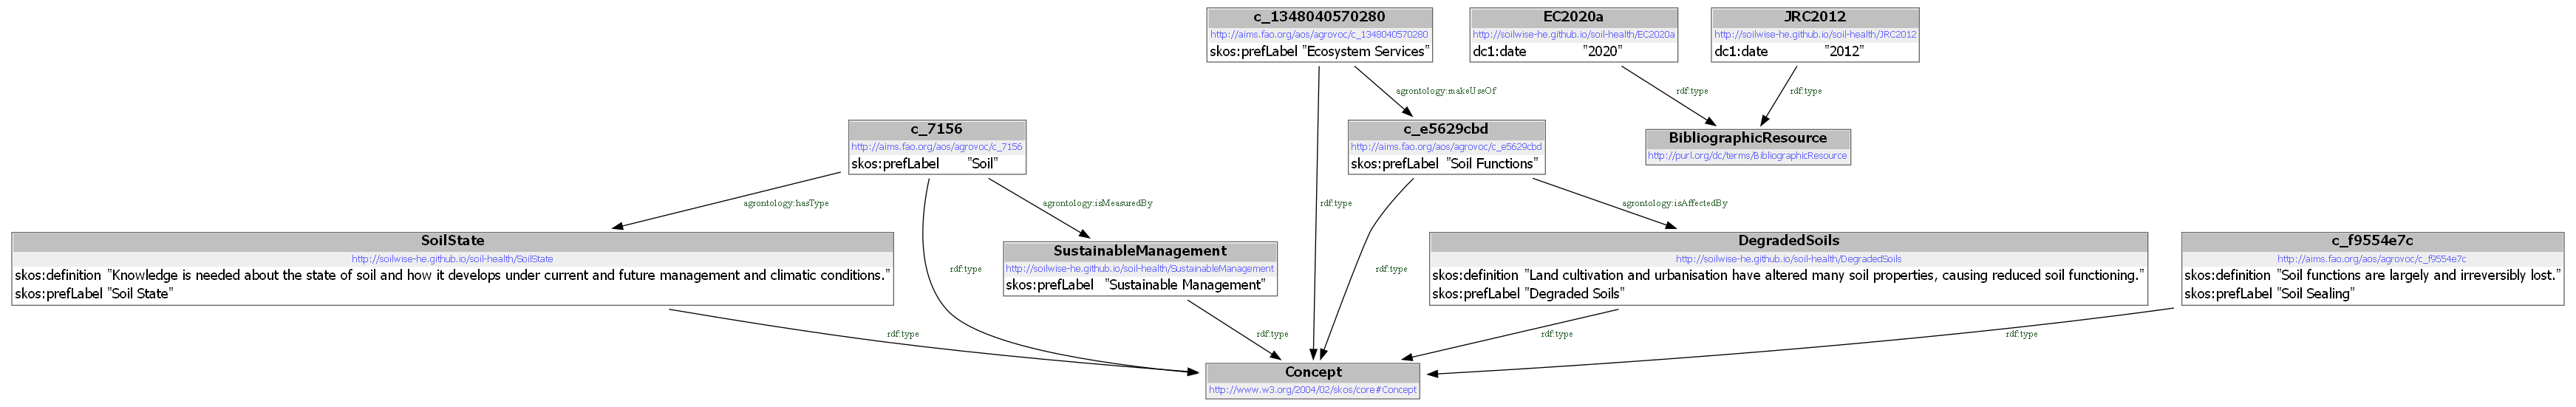

In [136]:
visualize(g_1)

### Evaluate different strategies

In [106]:
#Exact Match Precision, Recall and F1 
def compute_metrics(ground_truth_triples, generated_triples):
    true_positives = set(ground_truth_triples) & set(generated_triples)
    false_positives = set(generated_triples) - set(ground_truth_triples)
    false_negatives = set(ground_truth_triples) - set(generated_triples)

    precision = len(true_positives) / len(generated_triples) if generated_triples else 0
    recall = len(true_positives) / len(ground_truth_triples) if ground_truth_triples else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0

    return precision, recall, f1_score

In [107]:
# Regular Precision, Recall and F1 score
def compute_partial_metrics(gt_triples, gen_triples):
    # Dictionary to count matches for subjects, predicates, and objects
    matched_gt_indices = {
        'subject': set(),
        'predicate': set(),
        'object': set()
    }

    # Convert triples to lists to index them
    gt_triples_list = list(gt_triples)
    gen_triples_list = list(gen_triples)

    # Count matches
    match_counts = {'subject': 0, 'predicate': 0, 'object': 0}

    # Iterate over generated triples
    for idx_gen, (gen_s, gen_p, gen_o) in enumerate(gen_triples_list):
        # Iterate over ground truth triples
        for idx_gt, (gt_s, gt_p, gt_o) in enumerate(gt_triples_list):
            if gen_s == gt_s and idx_gt not in matched_gt_indices['subject']:
                match_counts['subject'] += 1
                matched_gt_indices['subject'].add(idx_gt)
            if gen_p == gt_p and idx_gt not in matched_gt_indices['predicate']:
                match_counts['predicate'] += 1
                matched_gt_indices['predicate'].add(idx_gt)
            if gen_o == gt_o and idx_gt not in matched_gt_indices['object']:
                match_counts['object'] += 1
                matched_gt_indices['object'].add(idx_gt)

    # Total potential matches are three times the count of generated triples
    total_possible = len(gen_triples) * 3
    total_matches = sum(match_counts.values())
    total_gt_possible = len(gt_triples) * 3

    # Calculate precision and recall
    precision = total_matches / total_possible if total_possible else 0
    recall = total_matches / total_gt_possible if total_gt_possible else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0

    return precision, recall, f1_score

In [108]:
#Results of zero-shot
precision, recall, f1_score = compute_metrics(set(load_graph(dataset[1]['rdf_graph_turtle'])), set(g_0))

print(f"Precision (EM): {precision:.4f}")
print(f"Recall (EM): {recall:.4f}")
print(f"F1 Score (EM): {f1_score:.4f}")

Precision (EM): 0.1739
Recall (EM): 0.1818
F1 Score (EM): 0.1778


In [109]:
#Results of zero-shot
precision, recall, f1_score = compute_partial_metrics(set(load_graph(dataset[1]['rdf_graph_turtle'])), set(g_0))

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Precision: 0.4420
Recall: 0.4621
F1 Score: 0.4519


In [139]:
#Results of one-shot
precision, recall, f1_score = compute_metrics(set(load_graph(dataset[1]['rdf_graph_turtle'])), set(g_1))

print(f"Precision (EM): {precision:.4f}")
print(f"Recall (EM): {recall:.4f}")
print(f"F1 Score (EM): {f1_score:.4f}")

Precision (EM): 0.4800
Recall (EM): 0.2727
F1 Score (EM): 0.3478


In [138]:
#Results of one-shot
precision, recall, f1_score = compute_partial_metrics(set(load_graph(dataset[1]['rdf_graph_turtle'])), set(g_1))

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Precision: 1.0000
Recall: 0.5682
F1 Score: 0.7246


### Post-process the knowledge graph

In [112]:
def parse_turtle(turtle_string):
    g = Graph()
    g.parse(data=turtle_string, format='turtle')
    return g

def merge_graphs(json_data):
    merged_graph = Graph()
    
    for item in json_data['dataset']:
        turtle_string = item['rdf_graph_turtle']
        graph = parse_turtle(turtle_string)
        merged_graph += graph
    
    return merged_graph

def remove_duplicates(graph):
    # Create a new graph to store unique triples
    unique_graph = Graph()
    
    # Iterate through all triples in the original graph
    for s, p, o in graph:
        # Check if the triple already exists in the unique graph
        if not (s, p, o) in unique_graph:
            unique_graph.add((s, p, o))
    
    return unique_graph

def main(file_path):
    merged_graph = merge_graphs(data)
    unique_graph = remove_duplicates(merged_graph)

    unique_graph.bind("agrovoc", agrovoc)
    unique_graph.bind("glosis_lh", glosis_lh)
    unique_graph.bind("ns0", NS0)

    # Serialize the final graph to Turtle format
    output_file = "soil_health_KG.ttl"
    unique_graph.serialize(destination=output_file, format="turtle")

if __name__ == "__main__":
    file_path = "text_RDF_gt.json"
    main(file_path)

### Interlink to external databases: a Zenodo example

In [238]:
# Define the API endpoint URL
api_url = "https://zenodo.org/api/records"

# query for datasources with 'soil'
# get first 200 datasources
# loop through pages to retrieve next part of data
# only get sources with status published
#  options: https://developers.zenodo.org/?python#list36

# list to gather all data through API requests
zenodo_data = []

# loop through pages to retreive next part of data
for i in range(1,11):
    print(f'loop num {i}')
    params = {'q': 'soil',
              'size':'20',
              'page':f'{i}',
              'status':'published',
              'sort':'bestmatch',
              'access_token': config['access_token_zenodo']}
    headers = {"Content-Type": "application/json"}

    # Make the API request
    response = requests.get(api_url,params = params, headers=headers)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the JSON response
        data = response.json()
        zenodo_data = zenodo_data + data['hits']['hits']
    else:
        print(f"Failed to retrieve data. Status code: {response.status_code}")
    
zenodo_data

loop num 1
loop num 2
loop num 3
loop num 4
loop num 5
loop num 6
loop num 7
loop num 8
loop num 9
loop num 10


[{'created': '2021-08-05T16:06:00.842433+00:00',
  'modified': '2021-08-06T01:48:27.870247+00:00',
  'id': 5159133,
  'conceptrecid': '5159132',
  'doi': '10.5281/zenodo.5159133',
  'conceptdoi': '10.5281/zenodo.5159132',
  'doi_url': 'https://doi.org/10.5281/zenodo.5159133',
  'metadata': {'title': 'Soil Survey of Scotland Staff (1970-1987). Soil maps of Scotland (partial coverage) at a scale of 1:25 000. Digital phase 8 release.',
   'doi': '10.5281/zenodo.5159133',
   'publication_date': '2021-08-04',
   'description': '<p>This is the digital dataset which was created by digitising the Soils of Scotland 1:25,000 Soil maps and the Soils of Scotland 1:25,000 Dyeline Masters. The Soils of Scotland 1:25,000 Soil maps were the source documents for the production of the Soils of Scotland 1:63,360 and 1:50,000 published map series. Where no 1:25,000 published maps exist 1:63,360 maps have been digitised for this data set, the field SOURCE_MAP describes the source of the data. The classific

In [239]:
# gather the id's in list to then extract data directly as dublincore representation
id_list = []
for i in range(0,len(zenodo_data)):
    id_list.append(zenodo_data[i]['id'])

In [240]:
# Convert HTML to plain text
class CleanHTML(HTMLParser):
    def reset(self) -> None:
        self.extracted_data = ""
        return super().reset()

    def remove_tags(self, html_data: str) -> str:
        """
        Args:
            html_data (str): HTML data which might contain tags.

        Returns:
            str: Data without any HTML tags. Forces feeding of any buffered data.
        """
        self.reset()
        self.feed(html_data)
        self.close()
        return self.extracted_data

    def handle_data(self, data: str) -> None:
        """
        Args:
            data (str): Html data extracted from tags to be processed.
        """
        self.extracted_data += data

p = CleanHTML()

In [ ]:
# Extract DublinCore standardized metadata and generate json with all data
zenodo_dc_data = {}
for i in range(len(id_list)):

    # Define the API endpoint URL
    api_url = f"https://zenodo.org/records/{id_list[i]}/export/dublincore"
    params = {'access_token': config['access_token_zenodo']}
    headers = {"Content-Type": "application/json"}

    # Make the API request
    response = requests.get(api_url, params = params, headers=headers, timeout=None)

    # Check if the request was successful
    if response.status_code == 200:
        try:
            # Parse the XML response
            root = ET.fromstring(response.content)

            # Define expected tags with namespace
            expected_tags = {
                "{http://purl.org/dc/elements/1.1/}creator": None,      # Initialize as None
                "{http://purl.org/dc/elements/1.1/}subject": None,      # Initialize as None
                "{http://purl.org/dc/elements/1.1/}date": None,         # Initialize as None
                "{http://purl.org/dc/elements/1.1/}title": None,        # Initialize as None
                "{http://purl.org/dc/elements/1.1/}description": None,   # Initialize as None
                "{http://purl.org/dc/elements/1.1/}identifier": None,    # Initialize as None
                "{http://purl.org/dc/elements/1.1/}language": None    # Initialize as None
            }

            # Create a dictionary for JSON conversion
            json_dict = {}

            # Check if the root has child elements
            if root:
                for child in root:
                    # Get full tag name, preserving namespace
                    tag = child.tag
                    text = p.remove_tags(unescape(child.text))  # Convert HTML entities to normal text

                    if tag in expected_tags:
                        if "creator" in tag or "subject" in tag:
                            if "creator" in tag:
                                if json_dict.get(tag) is None:
                                    json_dict[tag] = [text]
                                else:
                                    json_dict[tag].append(text)
                            elif "subject" in tag:
                                # Split subjects and strip spaces                              
                                subjects = [subj.strip() for subj in re.split(r'[;,]', text)]
                                if json_dict.get(tag) is None:                                  
                                    json_dict[tag] = subjects
                                else:
                                    json_dict[tag].extend(subjects)
                        else:
                            if json_dict.get(tag) is None:
                                json_dict[tag] = text  # Directly store as a string for date, title, description and identifier

                # Ensure all expected tags are included in the json_dict
                for tag, value in expected_tags.items():
                    if tag not in json_dict:
                        json_dict[tag] = value

                output_dict = {}
                # Adjusting the output to match the "dc:" prefix requirement
                for key, value in json_dict.items():
                    adjusted_key = key.split('}')[-1]  # Remove namespace URI
                    output_dict["dc:" + adjusted_key] = value

                zenodo_dict={
                    i:output_dict
                }
                
                #add to general json
                zenodo_dc_data.update(zenodo_dict)
            
            else:
                print("No repositories found in the response.")
        except ET.ParseError:
            print("Error: Unable to parse XML content.")
    else:
        # Print an error message if the request was not successful
        print(f"Error: Unable to fetch data. Status code: {response.status_code}")
        print(response.text)

In [249]:
# Convert metadata to RDF statements
# Dictionary of metadata entries, indexed by a unique key
metadata_entries = zenodo_dc_data

# Fill in all the missing keywords under named graph "generated"
# Create a ConjunctiveGraph to store quads
g_zenodo_extend = ConjunctiveGraph()

# Define named graphs
metadata_graph = URIRef("http://soilwise-he.github.io/soil-health/metadata")
generated_graph = URIRef("http://soilwise-he.github.io/soil-health/augmented")

# keywords generation
def generate_subjects(text):
    # Placeholder function to simulate generating subjects based on the title
    kw_model = KeyBERT()
    seed_keywords = ["soil"]

    keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 2), stop_words=None, seed_keywords=seed_keywords, use_mmr=True, diversity=0.5)
    keywords = [item[0] for item in keywords if item[1] > 0.5]
    
    return keywords

# Loop through each metadata entry
for entry_id, metadata in metadata_entries.items():
    if metadata['dc:language'] is None or metadata['dc:language'] == 'eng': 
        # Define the URI for the resource using its identifier
        resource_uri = URIRef(metadata['dc:identifier'])

        # Define the resource as a BibliographicResource
        g_zenodo_extend.add((resource_uri, RDF.type, DCTERMS.BibliographicResource, metadata_graph))
    
        # Add the title, date, and identifier
        g_zenodo_extend.add((resource_uri, DCTERMS.title, Literal(metadata['dc:title']), metadata_graph))
        g_zenodo_extend.add((resource_uri, DCTERMS.date, Literal(metadata['dc:date']), metadata_graph))
        g_zenodo_extend.add((resource_uri, DCTERMS.identifier, URIRef(metadata['dc:identifier']), metadata_graph))

        # Add creators, which can have multiple values
        for creator in metadata['dc:creator']:
            g_zenodo_extend.add((resource_uri, DCTERMS.creator, Literal(creator), metadata_graph))
    
        # Check if subjects are provided, otherwise generate them
        if metadata['dc:subject'] is None:
            generated_subjects = generate_subjects(f"{metadata['dc:title']}. {metadata['dc:description']}")
            for subject in generated_subjects:
                g_zenodo_extend.add((resource_uri, DCTERMS.subject, Literal(subject), generated_graph))
        else:
            for subject in metadata['dc:subject']:
                g_zenodo_extend.add((resource_uri, DCTERMS.subject, Literal(subject.strip()), metadata_graph))

# Output the graph in Turtle format
g_zenodo_extend.bind("ns0", NS0)

print(g_zenodo_extend.serialize(format="trig"))

@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix ns0: <http://soilwise-he.github.io/soil-health/> .

ns0:augmented {
    <https://doi.org/10.5061/dryad.2280gb5rk> dcterms:subject "elevation soil",
            "fungal diversity" .

    <https://doi.org/10.5061/dryad.8cz8w9gpg> dcterms:subject "soil microbial" .

    <https://doi.org/10.5061/dryad.m37pvmczk> dcterms:subject "rhizocompartments soil",
            "soil microbial" .

    <https://doi.org/10.5061/dryad.xpnvx0kh2> dcterms:subject "soil biochar",
            "soil organic" .

    <https://doi.org/10.5281/zenodo.10401745> dcterms:subject "soil hydraulic",
            "soil properties" .

    <https://doi.org/10.5281/zenodo.10605462> dcterms:subject "soil arthropods",
            "soil quality",
            "soildwelling insects" .

    <https://doi.org/10.5281/zenodo.1065954> dcterms:subject "rainfall mapping" .

    <https://doi.org/10.5281/zenodo.11399291> dcterms:subject "expansive soil",
            "soil lime",
     

In [256]:
# Interlink metadata quads with soil health knowledge graph
# Function to link concepts
def link_concepts(graph, concept_graph):
    # Extract all concept URIs and labels
    labels = {}
    for c in concept_graph.subjects(RDF.type, SKOS.Concept):
        pref_label = concept_graph.value(c, SKOS.prefLabel)
        labels[c] = [pref_label.lower() if pref_label else ""]

    for s, p, o, g in graph.quads((None, None, None, None)):
        subject_label = o.lower()
        for c, label_list in labels.items():
            if subject_label in label_list:
                graph.remove((s, p, o, g))
                graph.add((s, p, c, g))  # Preserve original predicate
                concept_graph.add((c, DCTERMS.source, s))

# Link concepts between metadata and concept graphs
link_concepts(g_zenodo_extend, unique_graph)

# Serialize the graphs to check the output
print("Concept Graph:")
print(unique_graph.serialize(format='turtle'))

Concept Graph:
@prefix agrovoc: <http://aims.fao.org/aos/agrovoc/> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix glosis_lh: <http://w3id.org/glosis/model/layerhorizon/> .
@prefix ns0: <http://soilwise-he.github.io/soil-health/> .
@prefix ns1: <http://aims.fao.org/aos/agrontology#> .
@prefix ns2: <http://qudt.org/schema/qudt/> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

agrovoc:c_1348040570280 a skos:Concept ;
    ns1:isInfluencedBy ns0:SoilHealth ;
    ns1:makeUseOf agrovoc:c_e5629cbd ;
    skos:prefLabel "Ecosystem Services" .

agrovoc:c_2482 a skos:Concept ;
    ns1:isAffectedBy agrovoc:c_7168 ;
    skos:prefLabel "Ecosystems" .

agrovoc:c_25398 a skos:Concept ;
    ns1:benefitsFrom agrovoc:c_a9645d28,
        ns0:SoilHealth ;
    skos:prefLabel "Plant Health" .

agrovoc:c_330883 a skos:Concept ;
    ns1:isAffectedBy agrovoc:c_8088,
        ns0:LandCulti

In [263]:
g_zenodo_extend.bind("agrovoc", agrovoc)
g_zenodo_extend.bind("ns0", NS0)

print("Metadata Graph:")
print(g_zenodo_extend.serialize(format='trig'))

Metadata Graph:
@prefix agrovoc: <http://aims.fao.org/aos/agrovoc/> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix ns0: <http://soilwise-he.github.io/soil-health/> .

ns0:augmented {
    <https://doi.org/10.5061/dryad.2280gb5rk> dcterms:subject "elevation soil",
            "fungal diversity" .

    <https://doi.org/10.5061/dryad.8cz8w9gpg> dcterms:subject "soil microbial" .

    <https://doi.org/10.5061/dryad.m37pvmczk> dcterms:subject "rhizocompartments soil",
            "soil microbial" .

    <https://doi.org/10.5061/dryad.xpnvx0kh2> dcterms:subject "soil biochar",
            "soil organic" .

    <https://doi.org/10.5281/zenodo.10401745> dcterms:subject agrovoc:c_330883,
            "soil hydraulic" .

    <https://doi.org/10.5281/zenodo.10605462> dcterms:subject agrovoc:c_a9645d28,
            "soil arthropods",
            "soildwelling insects" .

    <https://doi.org/10.5281/zenodo.1065954> dcterms:subject "rainfall mapping" .

    <https://doi.org/10.5281/zenodo.1

In [266]:
concept_graph_extended = ConjunctiveGraph()

for triple in unique_graph:
    concept_graph_extended.add(triple)

for quad in g_zenodo_extend.quads((None, None, None, None)):
    concept_graph_extended.add(quad)

concept_graph_extended.bind("agrovoc", agrovoc)
concept_graph_extended.bind("ns0", NS0)
concept_graph_extended.bind("glosis_lh", glosis_lh)

print(concept_graph_extended.serialize(format='trig'))
# Save the graph to a file
concept_graph_extended.serialize(destination="example_SWR.trig", format="trig")

@prefix agrovoc: <http://aims.fao.org/aos/agrovoc/> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix glosis_lh: <http://w3id.org/glosis/model/layerhorizon/> .
@prefix ns0: <http://soilwise-he.github.io/soil-health/> .
@prefix ns1: <http://aims.fao.org/aos/agrontology#> .
@prefix ns2: <http://qudt.org/schema/qudt/> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

ns0:augmented {
    <https://doi.org/10.5061/dryad.2280gb5rk> dcterms:subject "elevation soil",
            "fungal diversity" .

    <https://doi.org/10.5061/dryad.8cz8w9gpg> dcterms:subject "soil microbial" .

    <https://doi.org/10.5061/dryad.m37pvmczk> dcterms:subject "rhizocompartments soil",
            "soil microbial" .

    <https://doi.org/10.5061/dryad.xpnvx0kh2> dcterms:subject "soil biochar",
            "soil organic" .

    <https://doi.org/10.5281/zenodo.10401745> dcterms:subject agrovoc:c

<Graph identifier=N55f1989c0eaa475a81cbe23ead6d0272 (<class 'rdflib.graph.ConjunctiveGraph'>)>

### Validate the (extended) knowledge graph by question answering (with NLQ)

In [218]:
graph = RdfGraph(
    source_file="soil_health_KG.ttl",
    serialization="ttl",
)

In [219]:
llm = ChatOpenAI(model="chatgpt-4o-latest", temperature=0)
chain = GraphSparqlQAChain.from_llm(llm=llm, graph=graph, return_sparql_query=True, verbose=True)

In [220]:
graph.get_schema

'In the following, each IRI is followed by the local name and optionally its description in parentheses. \nThe RDF graph supports the following node types:\n<http://www.w3.org/2004/02/skos/core#Concept> (Concept, None), <http://qudt.org/schema/qudt/QuantityValue> (QuantityValue, None), <http://purl.org/dc/terms/BibliographicResource> (BibliographicResource, None)\nThe RDF graph supports the following relationships:\n<http://purl.org/dc/terms/source> (source, None), <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> (type, None), <http://aims.fao.org/aos/agrontology#benefitsFrom> (benefitsFrom, None), <http://www.w3.org/2004/02/skos/core#definition> (definition, None), <http://www.w3.org/2004/02/skos/core#broader> (broader, None), <http://www.w3.org/2004/02/skos/core#prefLabel> (prefLabel, None), <http://aims.fao.org/aos/agrontology#isComposedOf> (isComposedOf, None), <http://aims.fao.org/aos/agrontology#isAffectedBy> (isAffectedBy, None), <http://www.w3.org/2004/02/skos/core#closeMatch>

In [223]:
result = chain.invoke("""
    what is the difference between soil health and soil quality?

    Please only generate the pure SPARQL query without '```'.
    Note that the difference between concepts is labeled by "skos:scopeNote".
    Please generate case insensitive SPARQL query for string match.
    Please only output the final answer without the SPARQL query. Thank you!
""")

print(f"Final answer: {result['result']}")



> Entering new GraphSparqlQAChain chain...
Identified intent:
SELECT
Generated SPARQL:
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
SELECT ?difference
WHERE {
    ?concept1 skos:prefLabel ?label1 .
    ?concept2 skos:prefLabel ?label2 .
    FILTER (lcase(?label1) = "soil health" && lcase(?label2) = "soil quality") .
    ?concept1 skos:scopeNote ?difference .
}
Full Context:
[(rdflib.term.Literal('The actual capacity of a soil to perform its core functions and to provide ecosystem services.'),)]

> Finished chain.
Final answer: The actual capacity of a soil to perform its core functions and to provide ecosystem services.


In [224]:
query = result['sparql_query']

# Execute the query
for row in graph.query(query):
    print(f"{row.difference}")

The actual capacity of a soil to perform its core functions and to provide ecosystem services.
